## Import

In [1]:
import os
import math as m
from codes_gendrops_py.genSingleDrop import *
from codes_gendrops_py.fit_circle_through_3_points import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from cost_function import img2bw,ResizeImage
from PIL import Image
from remove_edge import *
import numpy as np

## Definate the remove needle function and cost function

In [2]:
def remove_needle(img_ori,savepath='./'):
    path=savepath+"cut_needle.png" #%(sigma, volume0, rneedle)

    w_ori,h_ori=img_ori.size

    scaling_ori=300/w_ori # reshape the origin image to weight 100

    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))

    left_edge=np.zeros(w_ori2)
    right_edge=np.zeros(w_ori2)
    for i in range(h_ori2):
        for j in range(w_ori2):
            if A[i,j-1]>=125 and A[i,j]<125:
                #print('Left position',i,j)
                left_edge[i]=j
            if A[i,j-1]<=125 and A[i,j]>125:
                #print('Right position',i,j)
                right_edge[i]=j

    needle=np.abs(left_edge-right_edge)

    end=0
    #print(needle.shape[0])
    for j in range(needle.shape[0]-1):
        j=j+1
        #print((needle[j]-needle[0])/needle[0])
        if end == 0:
            if abs((needle[j]-needle[0])/needle[0])>0.05:
                stopline=j
                #print(j)
                end=end+1
    #print(stopline)

    img_WON=np.zeros((h_ori2-stopline,w_ori2))
    for i in range(h_ori2):
        if i>=stopline:
            img_WON[i-stopline,:]=A[i,:]
            
    img=Image.fromarray(np.uint8(img_WON))
    img.save(path)
    return path

In [25]:
def cost_new(img_ori,img_syn,x,width=100,K=1,output=0):
    '''
    input:              
    x:                the origin point of synthetic image
    img_syn,img_ori:    the images that need to calculate the cost 
                        should be valued by 'Image.open(path)'
    K:                  the scaling of synthethic image
    output: 0 -->lost, 1-->C, else C,lost
    '''
    w_ori,h_ori=img_ori.size
    w_syn,h_syn=img_syn.size
    

    scaling_ori=width/w_ori # reshape the origin image to width 100
    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)
    scaling_syn=K*scaling_ori
    w_syn2=int(scaling_syn*w_syn)
    h_syn2=int(scaling_syn*h_syn)
    x=int(x)

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))
    one=np.ones((w_ori2-h_ori2,w_ori2))*255
    A=np.row_stack((A,one))


    B=img2bw(ResizeImage(img_syn,w_syn2,h_syn2))
    C=np.zeros((w_ori2,w_ori2))

    for i in range (w_ori2): # h
        for j in range(w_ori2): # w
            #print (h_ori2,w_ori2)
            #print(i,j)
            if j < x or j-x >= w_syn2 or i >= h_syn2 :
                 C[i,j]=A[i,j]
            else:
                if  A[i,j]==B[i,j-x]: # B[i-y,j-x]
                    C[i,j]=255
                else:
                    C[i,j]=0
    
    # pixel that same(T) different(F) and drop area
    t=0; f=0; 
    #drop_ori=0; drop_gen=0 
    for i in range (w_ori2):
        for j in range(h_ori2):
            if C[i,j]==0:
                f=f+1
            else:
                t=t+1
    lost=f/max(w_ori2*h_ori2,w_syn2*h_syn2)
    accurancy=1-lost

    if output == 0:
        return lost
    elif output == 1:
        return C
    else:
        return C,lost

## Definite the obtimize function

In [30]:
def obtimize_function5p(svrxk,path_ori=os.path.abspath('./images_experiment/220304_miliq_T17.7_S73.04.png'),path=os.path.abspath('./images_gen'),output=0):
    '''change the path_ori to select an different image'''
    sigma = svrxk[0]
    v0    = svrxk[1]
    rNe   = svrxk[2]
    x     = svrxk[3]
    k     = svrxk[4]

    # import img_ori
    path_ori=os.path.abspath('./images_experiment/220304_miliq_T17.7_S73.04.png')
    path_ori=cut_needle(Image.open(path_ori))

    # import img_syn
    path_syn=genSingleDrop(savepath=os.path.abspath('./images_gen'),sigma=sigma,
                            volume0=v0,rneedle=rNe,output=0)
    ## Crop the edge of syn image
    img_syn,path_syn = corp_margin(io.imread(path_syn))

    img_syn=Image.open(path_syn)
    img_ori=Image.open(path_ori)

    # calulate the lost
    if output == 0:
        lost=cost_new(x=x,img_syn=img_syn,img_ori=img_ori,K=k,output=output)
        return lost
    elif output == 1:
        C=cost_new(x=x,img_syn=img_syn,img_ori=img_ori,K=k,output=output)
        return C
    else:
        C,lost = cost_new(x=x,img_syn=img_syn,img_ori=img_ori,K=k,output=output)
        return C,lost

## Optimization start

 final_simplex: (array([[82.09807465, 15.3255713 ,  0.57400845, 30.98472249,  0.63274225],
       [82.09802551, 15.32555815,  0.57400905, 30.98477144,  0.63274055],
       [82.09806772, 15.32556777,  0.57400863, 30.98475937,  0.63274046],
       [82.09807702, 15.3255589 ,  0.57400828, 30.98477919,  0.63274021],
       [82.09814232, 15.3255724 ,  0.57400795, 30.98478073,  0.63274008],
       [82.09813302, 15.32556235,  0.57400839, 30.98475831,  0.63274056]]), array([0.08351351, 0.08351351, 0.08351351, 0.08351351, 0.08351351,
       0.08351351]))
           fun: 0.08351351351351351
       message: 'Optimization terminated successfully.'
          nfev: 151
           nit: 46
        status: 0
       success: True
             x: array([82.09807465, 15.3255713 ,  0.57400845, 30.98472249,  0.63274225])

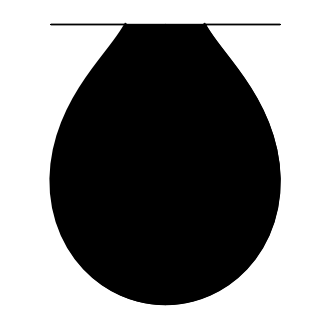

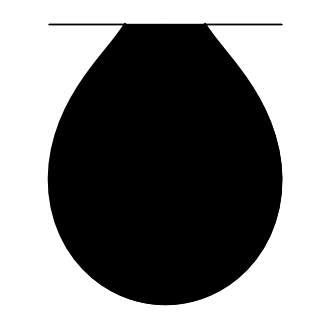

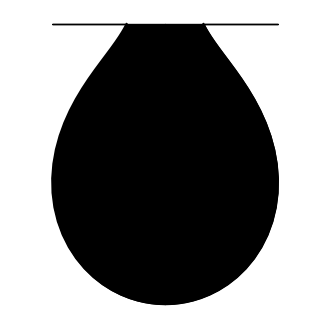

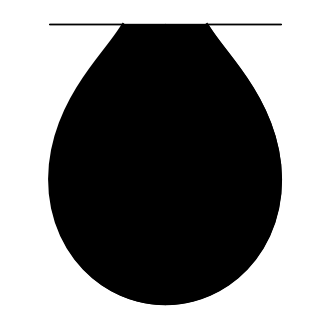

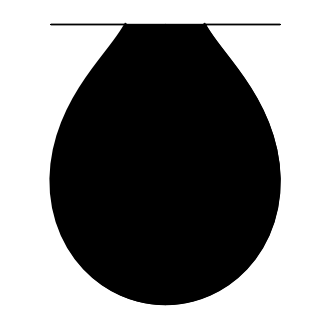

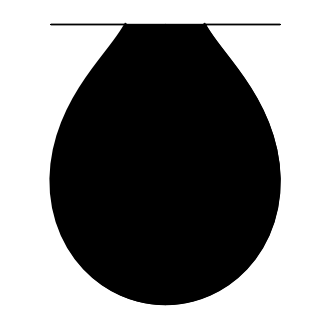

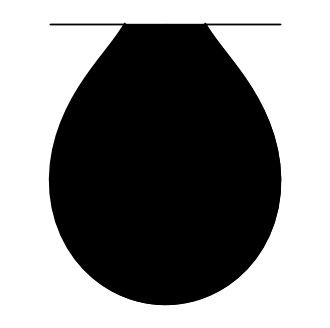

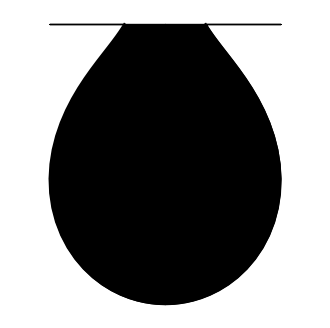

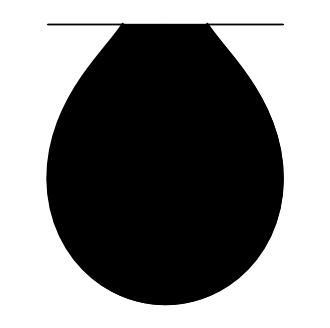

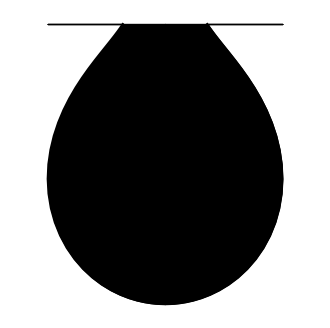

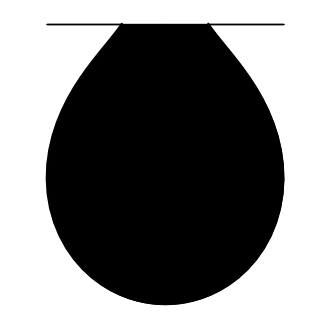

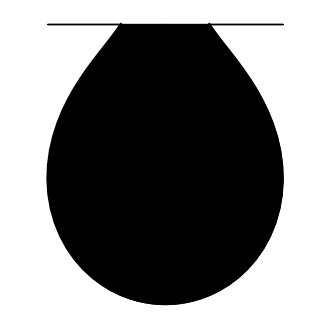

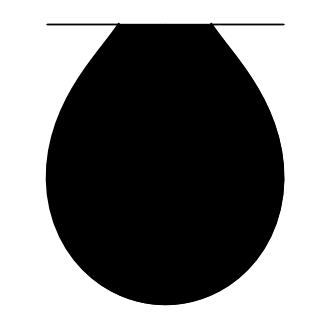

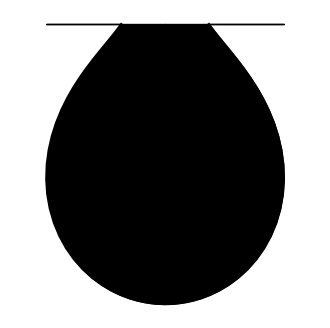

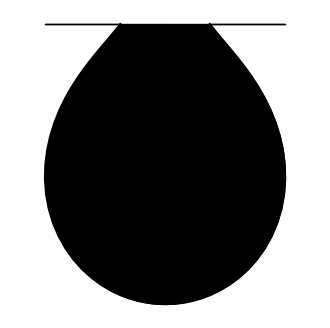

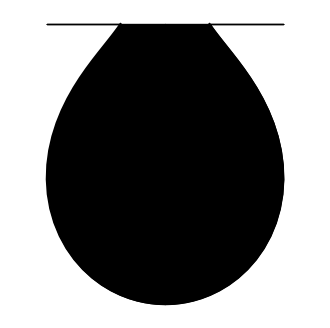

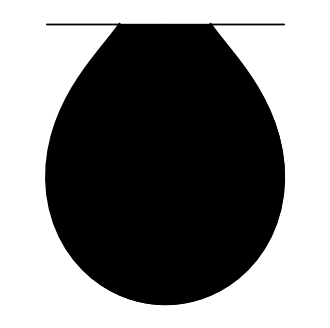

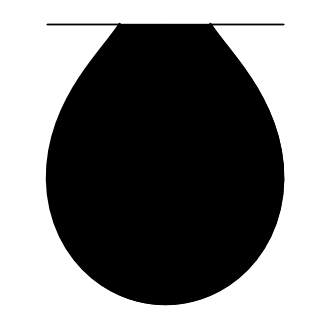

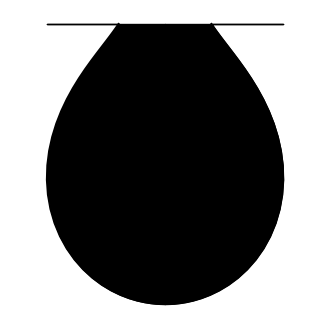

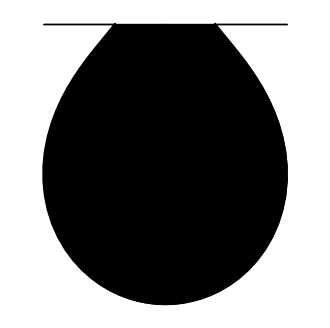

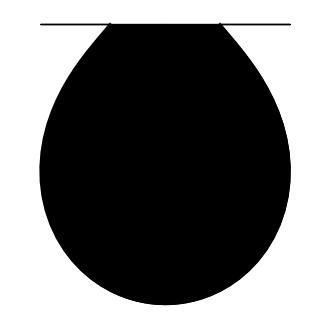

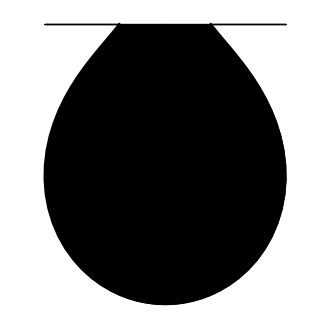

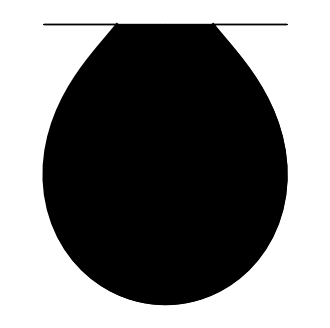

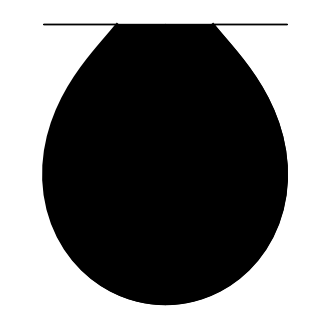

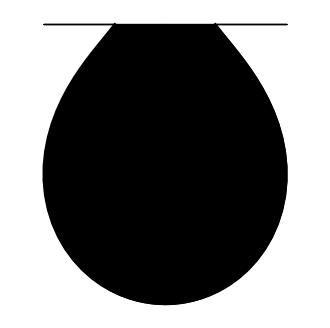

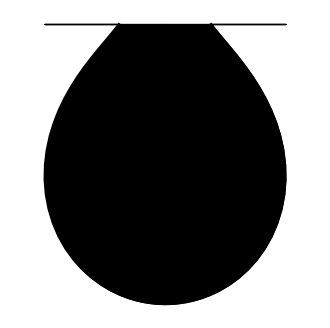

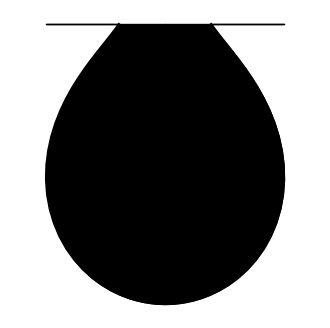

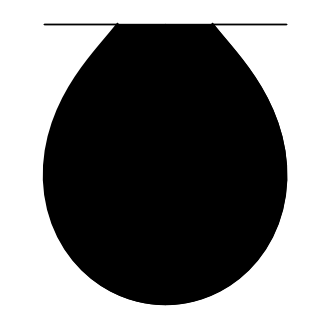

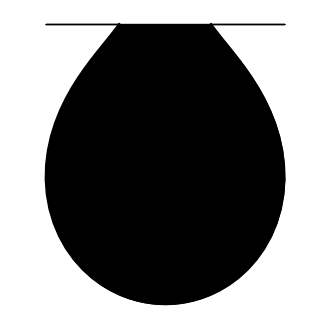

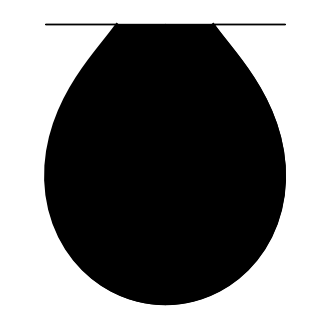

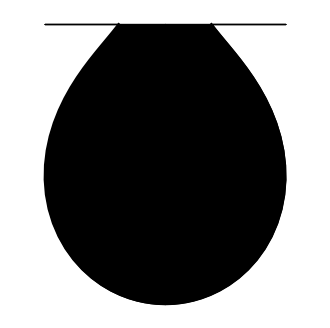

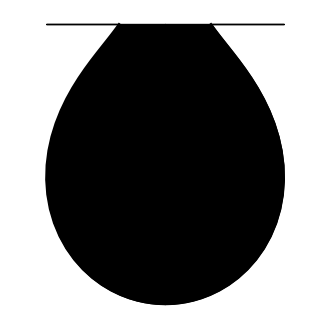

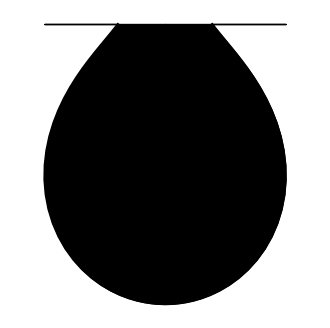

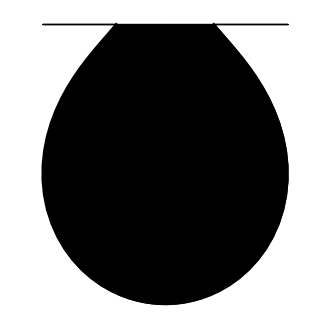

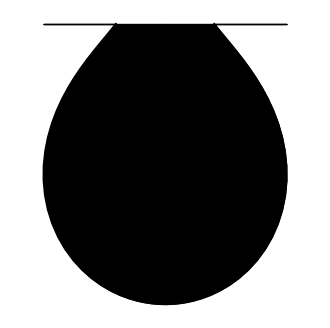

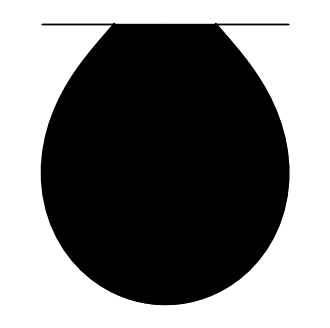

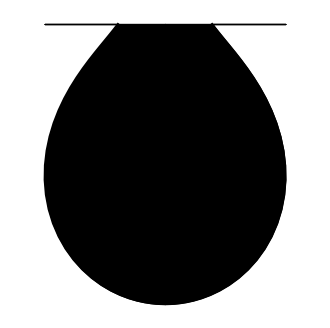

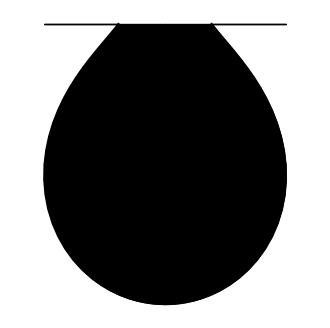

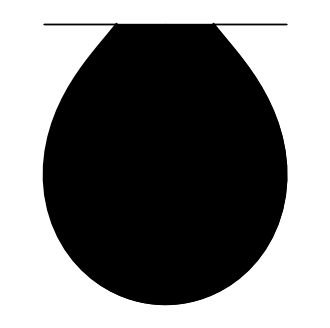

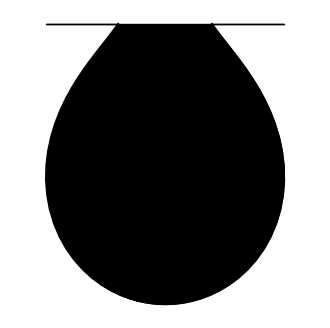

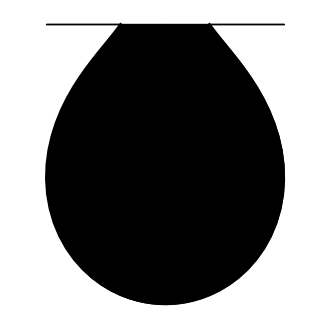

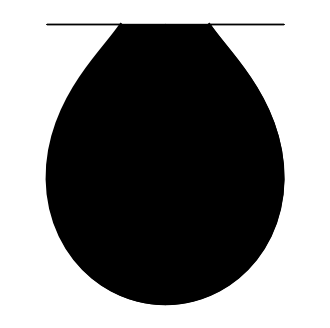

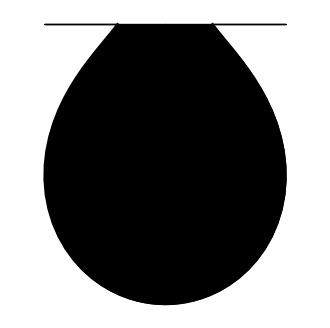

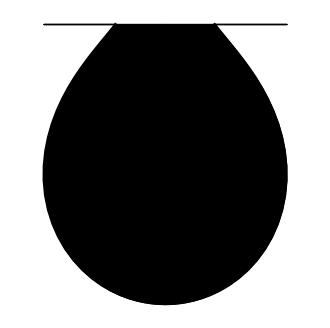

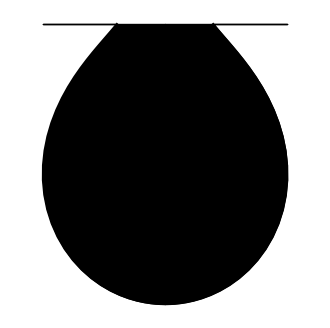

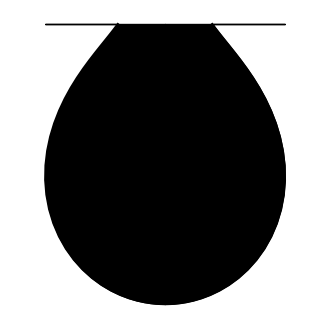

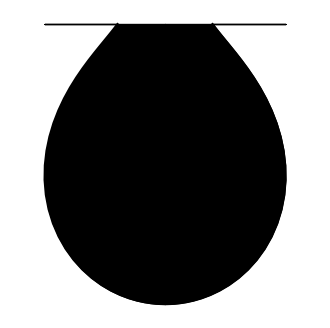

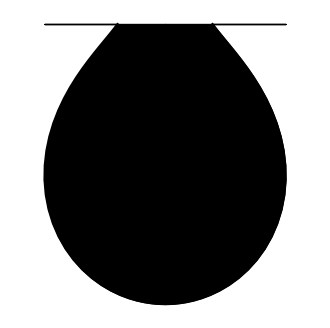

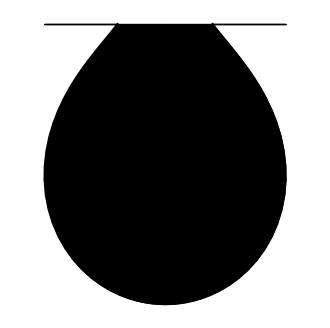

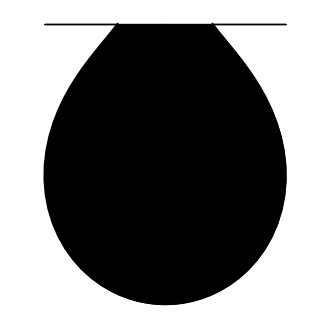

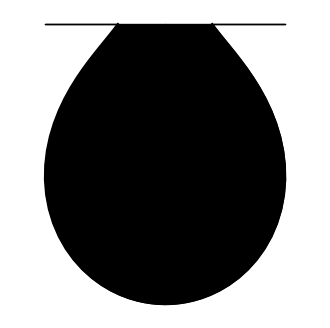

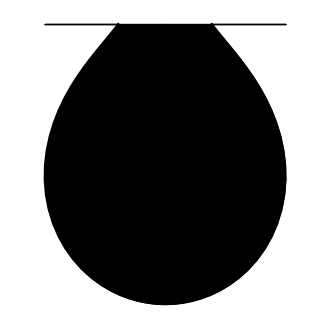

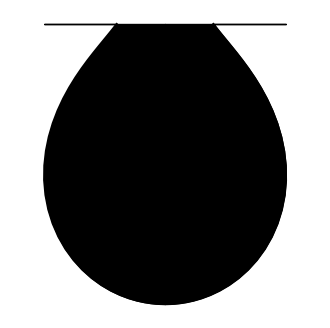

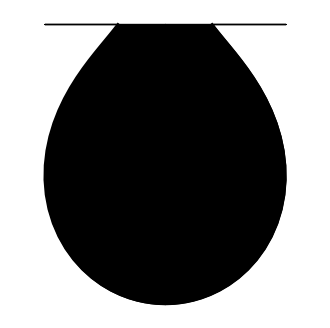

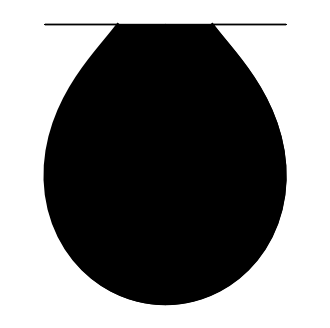

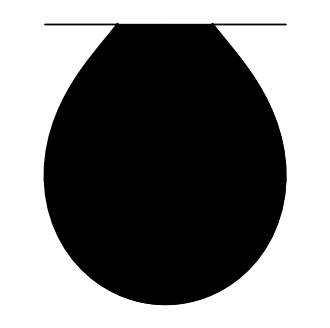

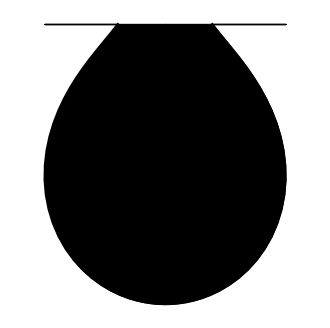

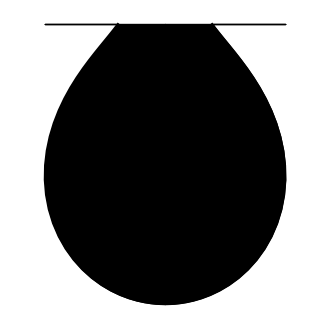

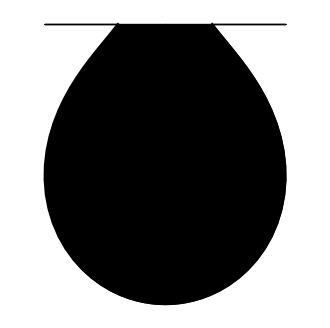

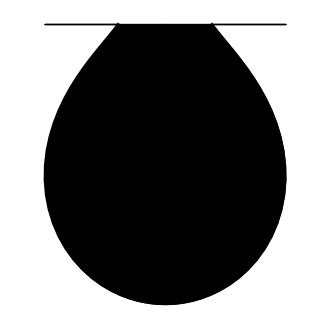

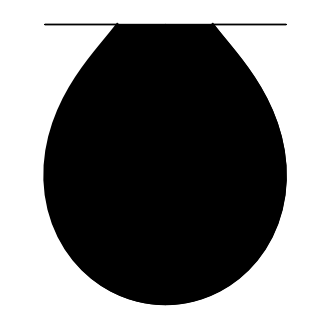

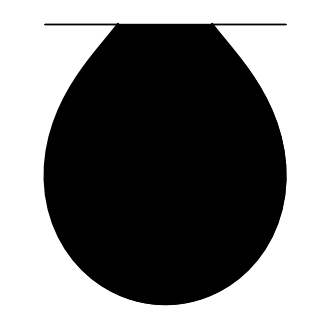

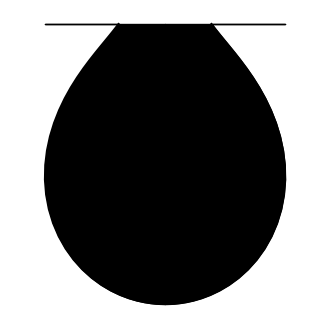

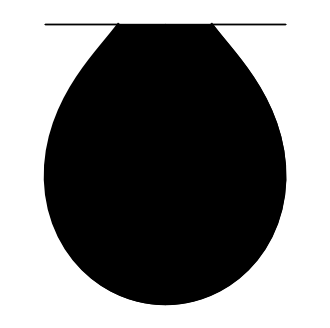

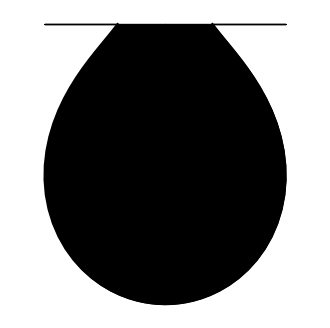

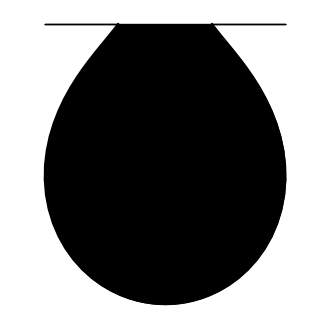

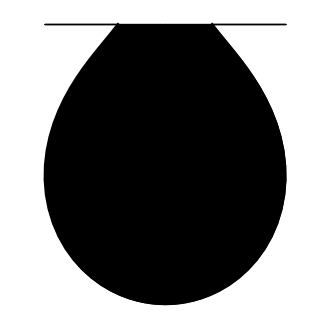

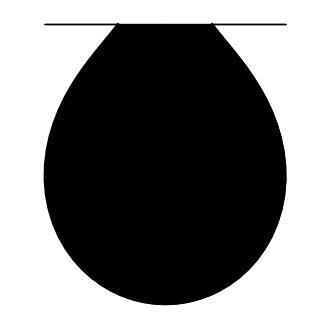

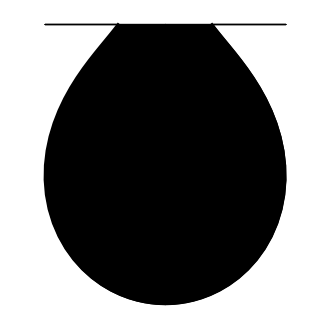

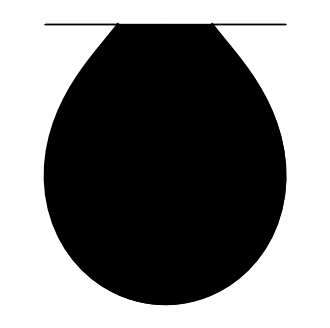

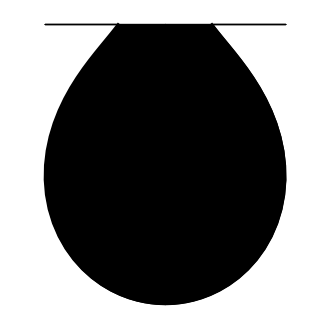

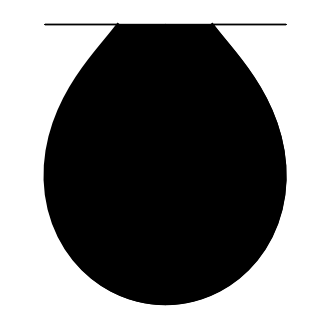

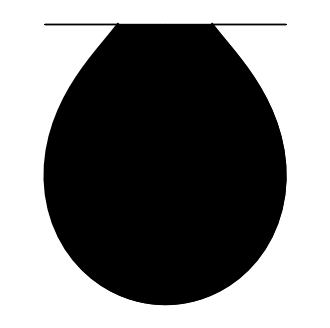

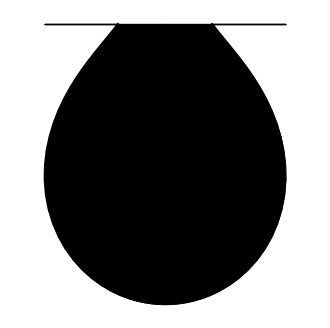

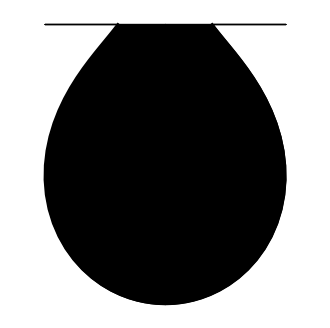

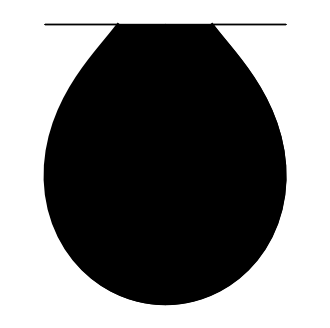

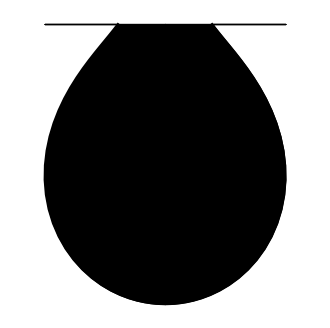

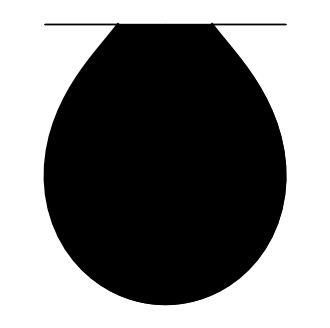

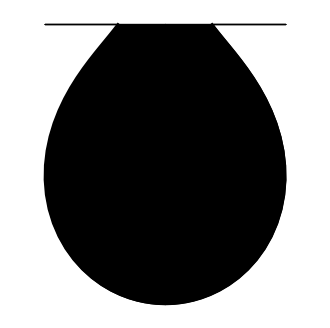

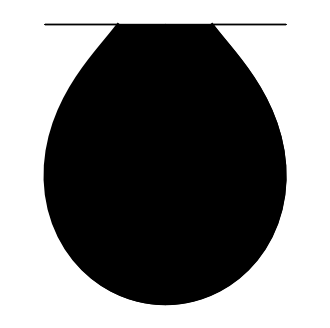

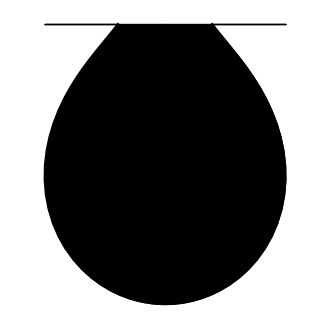

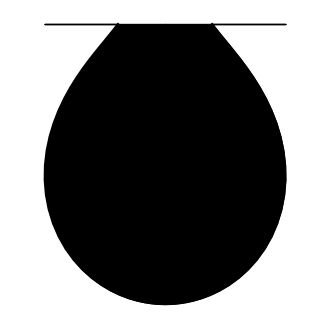

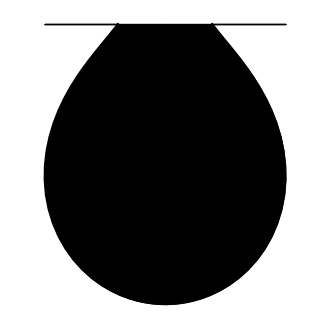

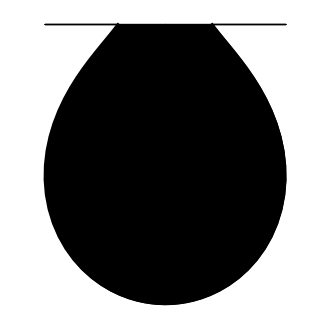

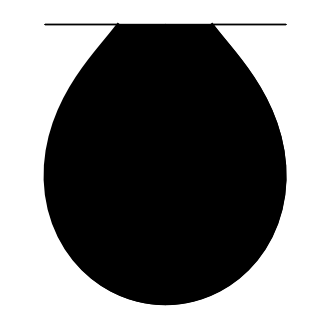

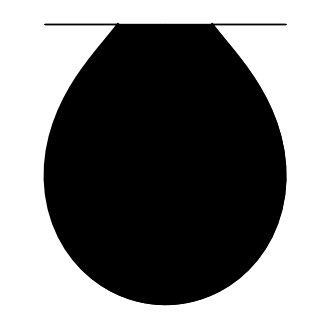

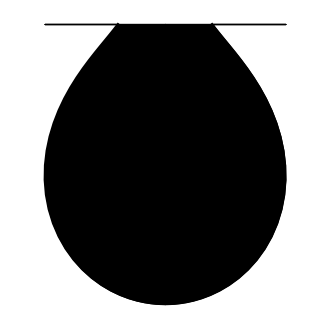

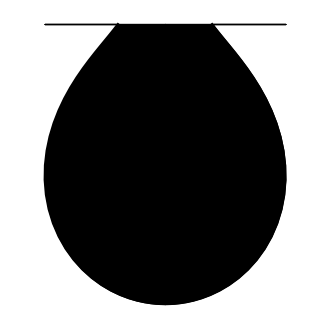

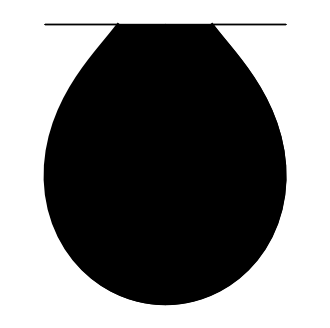

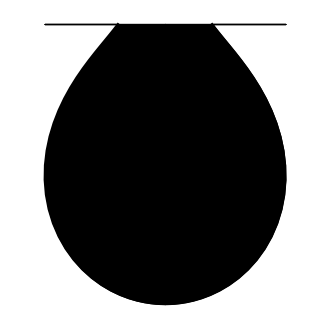

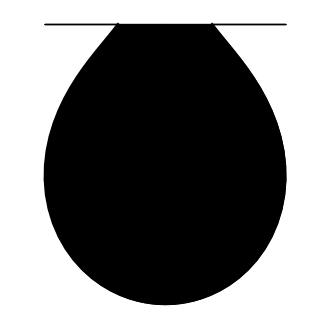

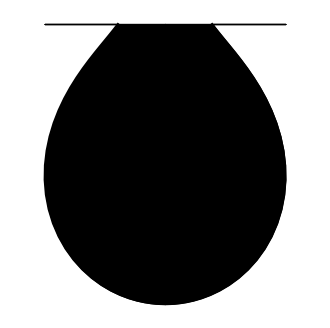

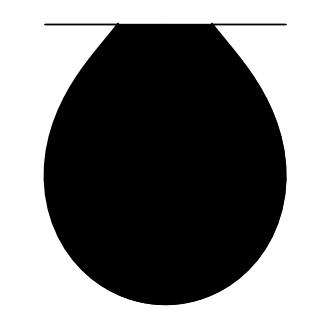

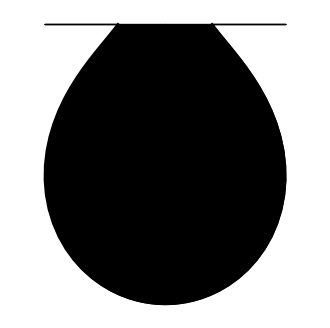

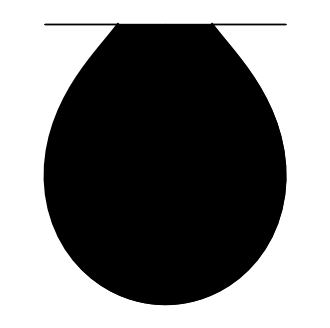

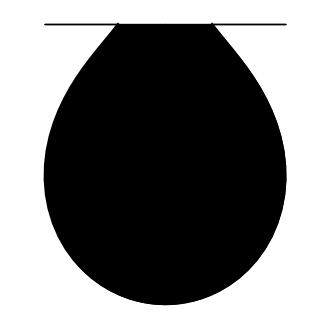

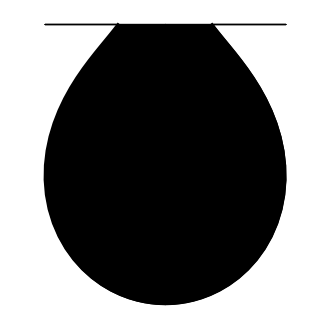

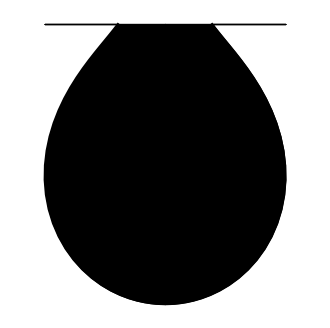

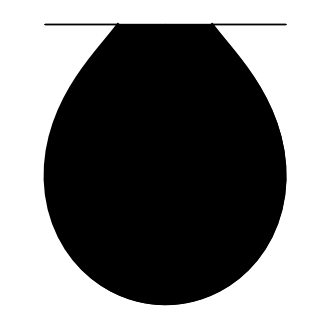

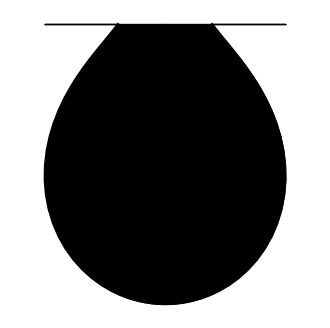

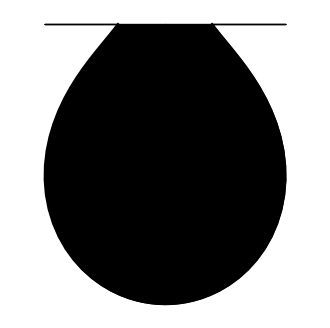

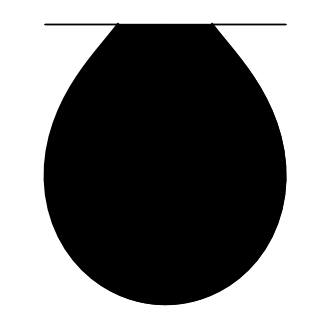

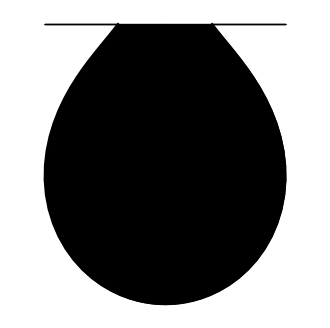

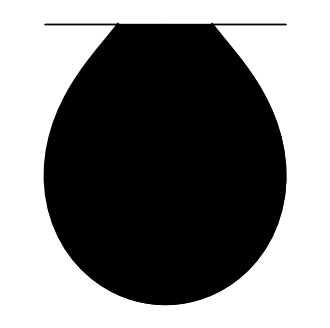

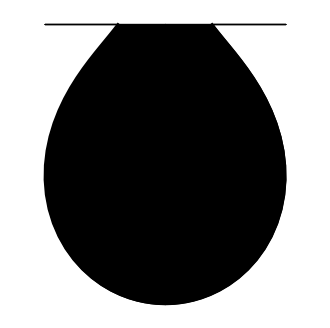

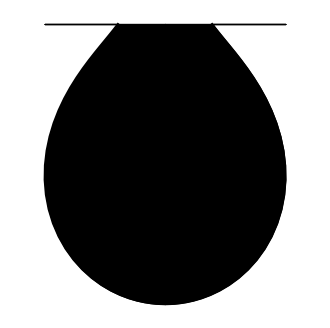

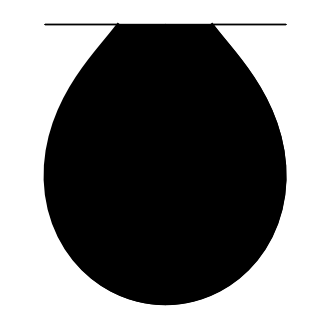

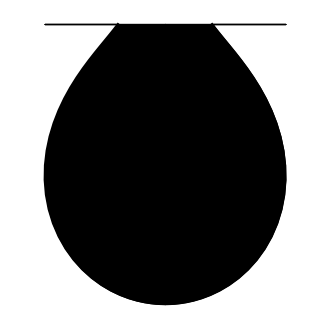

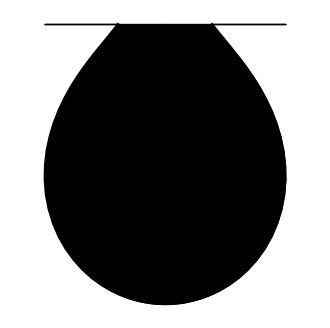

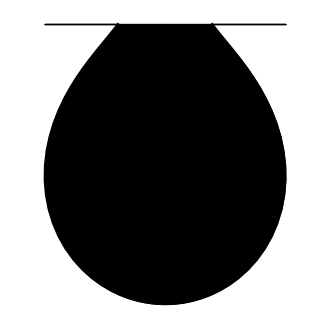

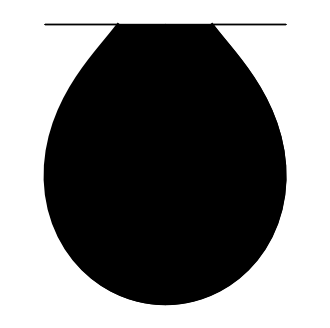

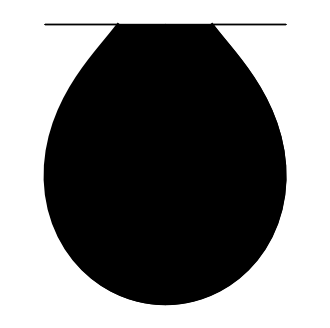

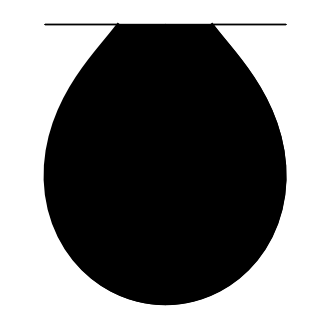

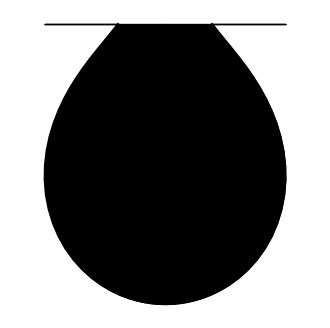

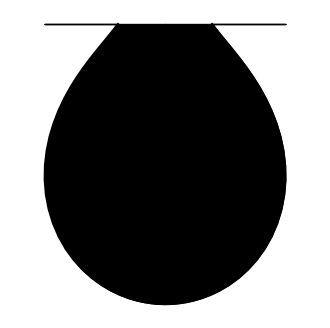

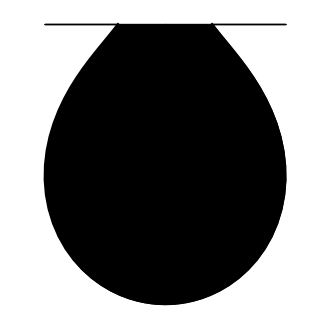

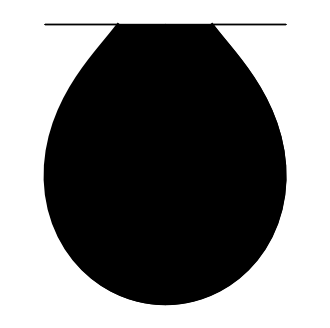

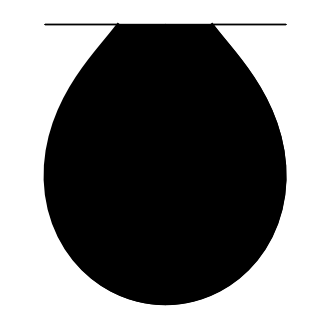

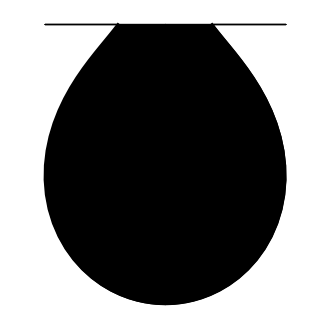

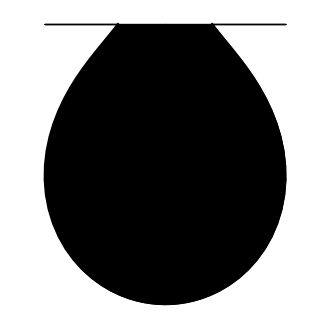

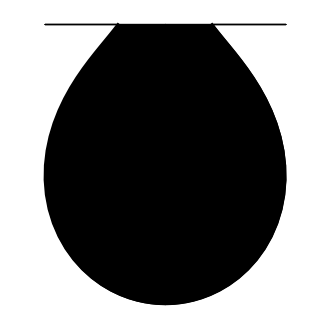

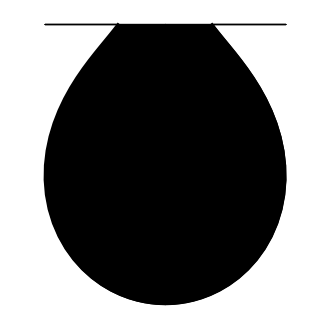

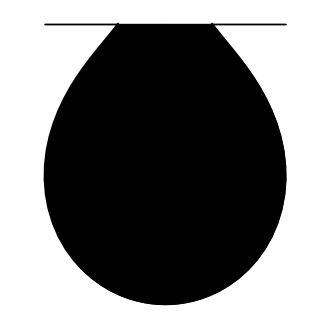

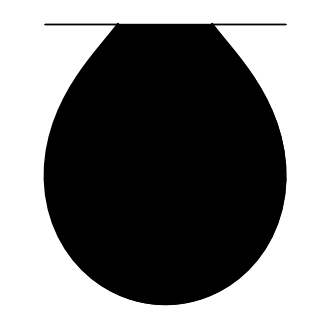

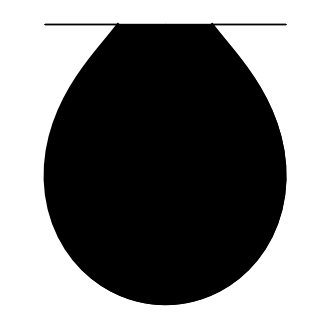

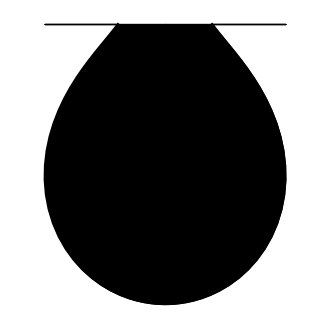

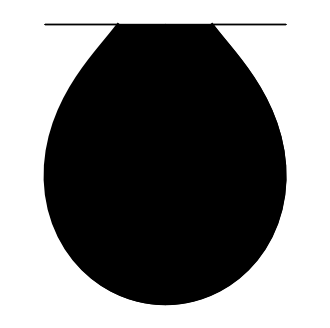

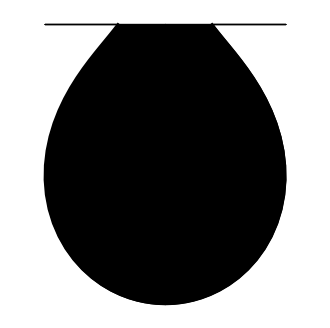

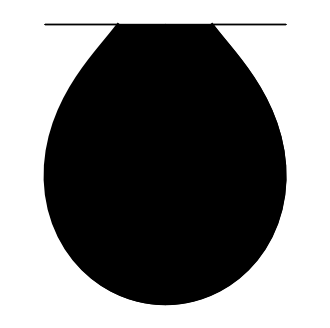

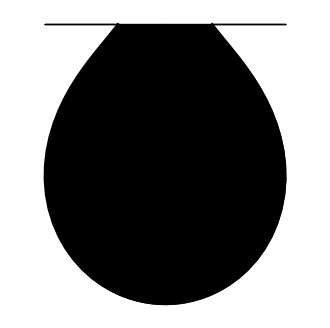

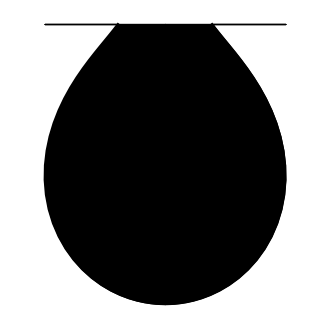

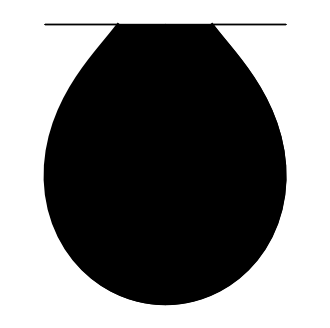

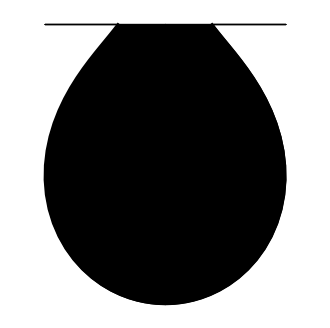

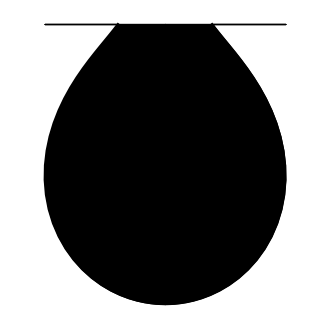

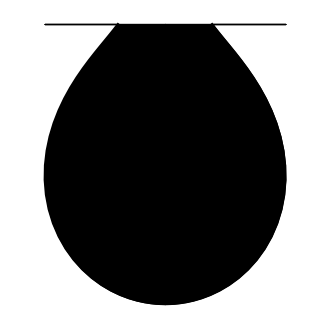

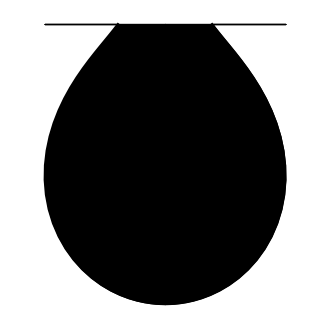

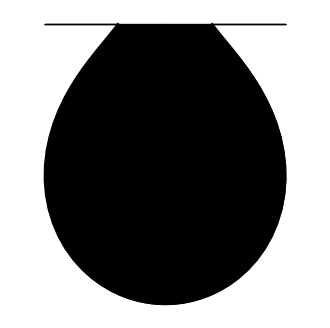

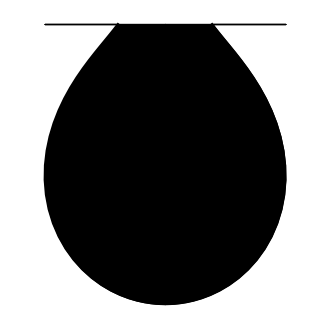

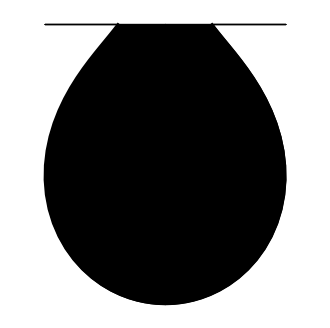

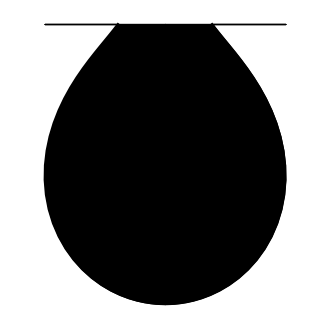

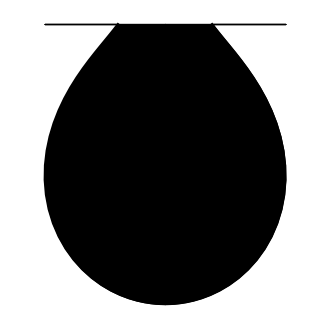

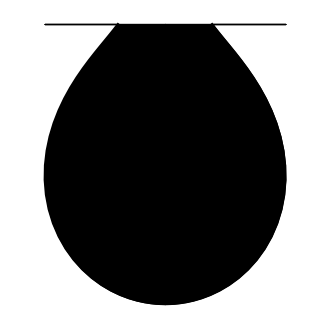

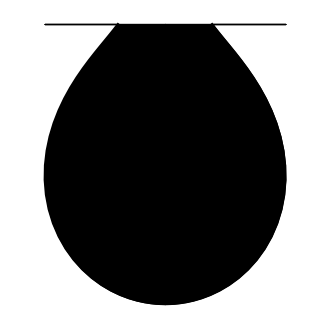

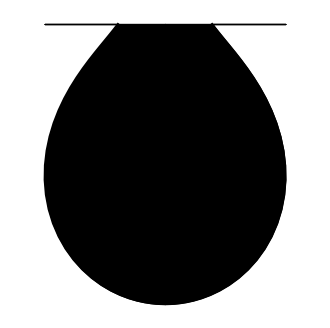

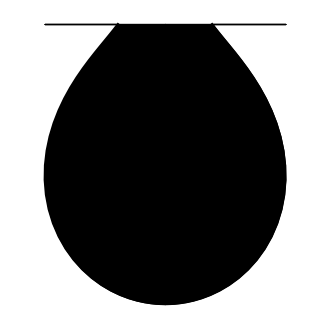

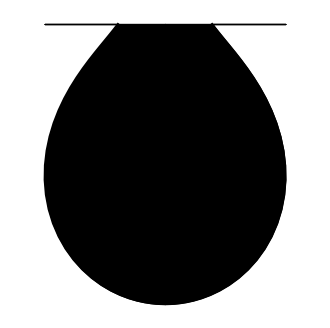

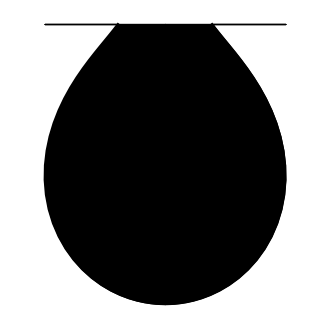

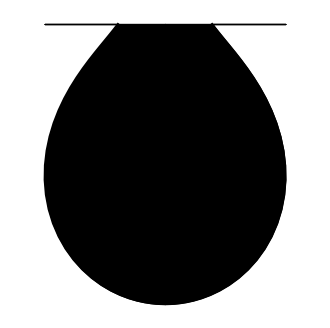

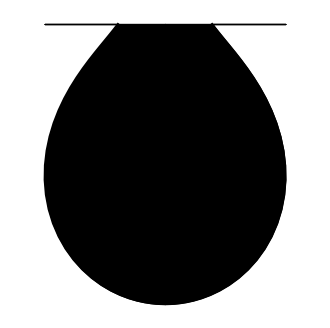

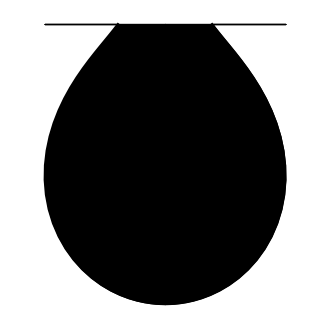

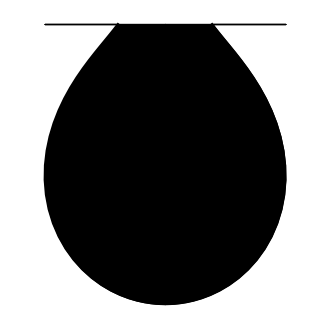

In [31]:
import scipy.optimize
# use scipy obtimaize the parameter
x0=np.asarray((75,15,0.5,30,1))
#sigma; v0; length_Ne,r_Ne; x,y; scaling_rate;
scipy.optimize.minimize(obtimize_function5p,x0,method='nelder-mead')

## Show the result

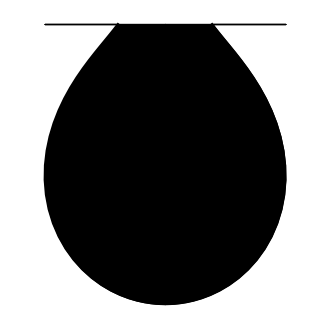

In [34]:
x=np.array([82.09807465, 15.3255713 ,  0.57400845, 30.98472249,  0.63274225])
xc=obtimize_function5p(x,output=1)

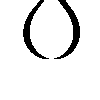

In [35]:
Image.fromarray(np.uint8(xc))